In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import pandas as pd
from scipy.optimize import curve_fit

# Coil-globule transition

In [2]:
def fit_fn(x,a,b):
    return a*x**b

In [4]:
path="/work/cms16/sb95/SAW_coil_globule"
Rg={}
for val1 in os.listdir(path):
    if 'epsilon_' in val1:
        chi = float(val1.split("epsilon_")[-1])
        if chi not in list(Rg.keys()):
                Rg[chi] = {}
        for val2 in os.listdir(os.path.join(path, val1)):
            temp = float(val2.split('temp_')[-1])
            if temp not in list(Rg[chi].keys()):
                    Rg[chi][temp] = [[],[]]
                    
            for val3 in sorted(os.listdir(os.path.join(path, val1, val2)), key=lambda x: float(x.split('N_')[-1])):
                N = float(val3.split('N_')[-1])
                
                rgval=[]
                for val4 in os.listdir(os.path.join(path, val1, val2, val3)):
                    if 'energy_report' in val4:
                        # print(val1,val2,val3,val4)
                        try:
                            rg=np.loadtxt(os.path.join(path,val1, val2, val3, val4), skiprows=1, usecols=[2]).mean()
                            if rg>800: continue
                            rgval.append(rg)
                        except(): pass
                Rg[chi][temp][0].append(N)
                Rg[chi][temp][1].append(np.mean(rgval))
                # print(chi, temp, N, np.mean(rgval))

print(Rg.keys())    

dict_keys([1.0])


[0.49433984 0.32822124] 3.701867856606148e-07 0.0006084297705245979
[0.65430167 0.30455603] 1.4192209368697325e-05 0.0037672548850187088
[1.2506133  0.23737816] 0.00022454914110214643 0.01498496383386181
[2.16469434 0.24215902] 0.002639486885627363 0.051375936834547
[0.46045066 0.55894905] 1.4524022270349966e-05 0.003811039526211971
[0.33086275 0.62392231] 0.0004176921109237053 0.020437517239716405
[0.26877551 0.66496639] 0.0010651772877477066 0.03263705390729541
[0.34571129 0.63567444] 7.698317548277274e-05 0.008774005669178289


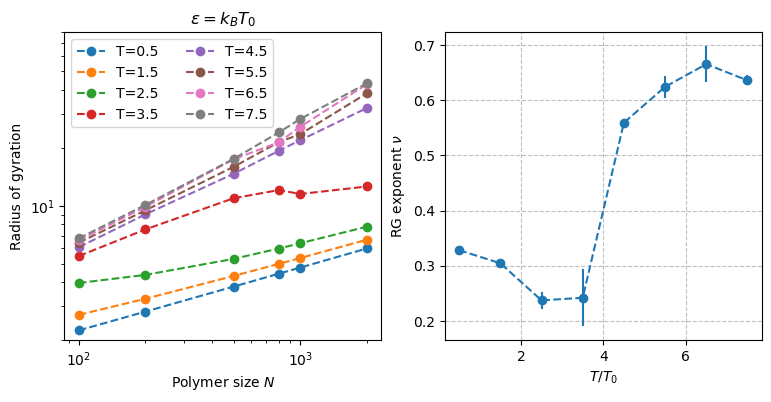

In [5]:
chi=1.0
Nvals = np.logspace(1.5,3.5,10)
fig, ax = plt.subplots(1,2, figsize=(9,4), dpi=100)
nu=[[],[]]
temp=[]
for T in sorted(Rg[chi].keys()):
    ax[0].loglog(np.array(Rg[chi][T])[0],np.array(Rg[chi][T])[1],'o--', label=f"T={T/120.0:.1f}")
    ax[0].set_title("$\\epsilon=k_BT_0$")
    popt,pcov = curve_fit(fit_fn,np.array(Rg[chi][T])[0],np.array(Rg[chi][T])[1])
    print(popt,pcov[1][1], np.sqrt(pcov[1,1]))
    nu[0].append(popt[1])
    nu[1].append(np.sqrt(pcov[1,1]))
    temp.append(T)

ax[0].legend(ncols=2)
ax[0].set_ylim(2,80)
ax[0].set_ylabel("Radius of gyration")
ax[0].set_xlabel("Polymer size $N$")
ax[1].errorbar(np.array(temp)/120.0, nu[0], yerr=nu[1], fmt='o--')
ax[1].set_xlabel("$T/T_0$")
ax[1].set_ylabel("RG exponent $\\nu$")
ax[1].grid(alpha=0.8, which='both', ls='--')
# ax[1].set_ylim(0.,1)


# Force extended globule

## Simulations

In [1]:
from pathlib import Path
import os
# SRC='/home/sb95/ChromatinDynamics/src'
SRC = os.path.join(Path.cwd().parent,'src')
print(SRC)

/Users/sb95/Library/CloudStorage/Box-Box/Research_current/ChromatinDynamics/src


In [23]:
import sys
sys.path.append(SRC)
from Topology import TopologyGenerator
from ChromatinDynamics import ChromatinDynamics
import openmm.unit as unit
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [3]:
generator = TopologyGenerator()
generator.gen_top([500])


In [261]:
sim = ChromatinDynamics(
        topology=generator.topology,
        platform_name="OpenCL", 
        name=f'test',
        output_dir=f"output",
        console_stream=True,
        )


2025-04-13 13:28:38,359 | INFO | ChromatinDynamics | ************************************************************
2025-04-13 13:28:38,361 | INFO | ChromatinDynamics |                      Chromatin Dynamics                     
2025-04-13 13:28:38,361 | INFO | ChromatinDynamics | ************************************************************
2025-04-13 13:28:38,362 | INFO | ChromatinDynamics | Storing output in output
2025-04-13 13:28:38,363 | INFO | ChromatinDynamics | System initialized with 500 particles.
2025-04-13 13:28:38,364 | INFO | Platforms | Platform 'OpenCL' is available and selected.
2025-04-13 13:28:38,364 | INFO | ChromatinDynamics | force_field_manager initialized. Use this to add forces to the system before setting up simulation.
2025-04-13 13:28:38,365 | INFO | ChromatinDynamics | ------------------------------------------------------------


In [262]:
sim.force_field_manager.add_harmonic_bonds(k=200.0, r0=1.0, group=0)
sim.force_field_manager.add_lennard_jones_force(epsilon=1.0, sigma=1.0, group=1)
sim.force_field_manager.constrain_monomer_pos(mono_id=0, pos=[0.0,0.0,0.0], group=2, k=200.0)
# sim.force_field_manager.constrain_monomer_pos(mono_id=sim.num_particles-1, pos=[0.0,0.0,80.0], group=2, k=10.0)
sim.force_field_manager.apply_force_z_axis(mono_id=sim.num_particles-1, fz=5.0, group=3)


2025-04-13 13:28:43,472 | INFO | Forcefield | Adding 499 harmonic bonds with parameters:
2025-04-13 13:28:43,473 | INFO | Forcefield | length: 1.0, spring constant (k): 200.0, group: 0
2025-04-13 13:28:43,474 | INFO | Forcefield | HarmonicBonds force successfully added to system.
2025-04-13 13:28:43,474 | INFO | Forcefield | --------------------------------------------------
2025-04-13 13:28:43,475 | INFO | Forcefield | Adding Lennard-Jones force:
2025-04-13 13:28:43,476 | INFO | Forcefield | epsilon=1.0, sigma=1.0, cutoff=5.0, group=1
2025-04-13 13:28:43,477 | INFO | Forcefield | Added exclusions from bonded monomers.
2025-04-13 13:28:43,478 | INFO | Forcefield | LennardJones force successfully added to system.
2025-04-13 13:28:43,478 | INFO | Forcefield | --------------------------------------------------
2025-04-13 13:28:43,479 | INFO | Forcefield | MonoPosConstraint force successfully added to system.
2025-04-13 13:28:43,479 | INFO | Forcefield | -----------------------------------

In [263]:
    
sim.simulation_setup(
    init_struct='saw3d',
    integrator='langevin',
    temperature=120.0,
    timestep=0.001,
    save_pos=True,
    save_energy=True,
    energy_report_interval=1000,  
    pos_report_interval=10_000,              
    )


2025-04-13 13:28:45,822 | INFO | ChromatinDynamics | ------------------------------------------------------------
2025-04-13 13:28:45,823 | INFO | Integrators | Valid integrators: ['langevin', 'brownian', 'active-brownian']| Selected: langevin
2025-04-13 13:28:45,824 | INFO | Integrators | LangevinIntegrator: temperatute=120.0 | friction=0.1 | timestep=0.001
2025-04-13 13:28:45,844 | INFO | ChromatinDynamics | Setting up context...
2025-04-13 13:28:45,851 | INFO | Utilities | 3D SAW created after 1 attempt(s). Position shape: (500, 3)
2025-04-13 13:28:45,853 | INFO | ChromatinDynamics | Simulation set up complete!
2025-04-13 13:28:45,854 | INFO | ChromatinDynamics | ------------------------------------------------------------------------------------------------------------------------
2025-04-13 13:28:45,854 | INFO | ChromatinDynamics | Index  Force Class                    Force Name           Group    Particles    Bonds        Exclusions   P.E./Particle       
2025-04-13 13:28:45,855

In [264]:
sim.pos_reporter.pause()
sim.run(50_000) #equilibrate and dont save rg
sim.pos_reporter.resume()
sim.print_force_info()


2025-04-13 13:28:47,536 | INFO | ChromatinDynamics | ------------------------------------------------------------
2025-04-13 13:28:47,537 | INFO | ChromatinDynamics | Running simulation for 50000 steps...
2025-04-13 13:28:51,921 | INFO | ChromatinDynamics | Completed 50000 steps in 4.38s (11406 steps/s)
2025-04-13 13:28:51,922 | INFO | ChromatinDynamics | ------------------------------------------------------------
2025-04-13 13:28:51,922 | INFO | ChromatinDynamics | ------------------------------------------------------------------------------------------------------------------------
2025-04-13 13:28:51,923 | INFO | ChromatinDynamics | Index  Force Class                    Force Name           Group    Particles    Bonds        Exclusions   P.E./Particle       
2025-04-13 13:28:51,923 | INFO | ChromatinDynamics | ------------------------------------------------------------------------------------------------------------------------
2025-04-13 13:28:51,924 | INFO | ChromatinDynamics |

In [265]:
for _ in range(100):
    sim.run(10_000)
        
sim.pos_reporter.close()

2025-04-13 13:28:57,177 | INFO | ChromatinDynamics | ------------------------------------------------------------
2025-04-13 13:28:57,178 | INFO | ChromatinDynamics | Running simulation for 10000 steps...
2025-04-13 13:28:58,098 | INFO | ChromatinDynamics | Completed 10000 steps in 0.92s (10879 steps/s)
2025-04-13 13:28:58,098 | INFO | ChromatinDynamics | ------------------------------------------------------------
2025-04-13 13:28:58,099 | INFO | ChromatinDynamics | ------------------------------------------------------------
2025-04-13 13:28:58,099 | INFO | ChromatinDynamics | Running simulation for 10000 steps...
2025-04-13 13:28:58,963 | INFO | ChromatinDynamics | Completed 10000 steps in 0.86s (11588 steps/s)
2025-04-13 13:28:58,963 | INFO | ChromatinDynamics | ------------------------------------------------------------
2025-04-13 13:28:58,963 | INFO | ChromatinDynamics | ------------------------------------------------------------
2025-04-13 13:28:58,964 | INFO | ChromatinDynami

In [266]:
pos = h5py.File('output/test_positions.cndb','r')
pos.keys()

<KeysViewHDF5 ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']>

18


(0.0, 80.0)

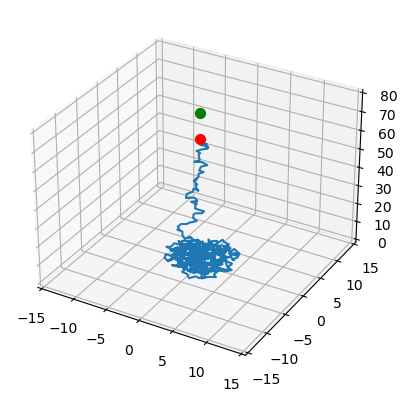

In [361]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
n=str(np.random.randint(0,99))
print(n)
ax.plot(pos[n][:,0], pos[n][:,1], pos[n][:,2])
ax.scatter(pos[n][-1,0], pos[n][-1,1], pos[n][-1,2], 'o', s=50, c='r')
ax.scatter(0, 0, 80, 'o', s=50, c='g')
ax.set_xlim(-15,15)
ax.set_ylim(-15,15)
ax.set_zlim(0,80)

## Analysis

In [2]:
os.listdir("/work/cms16/sb95/SAW_globule_extension_const_ext/")

['launcher_jobs_sim8',
 'slurm-95433.out',
 'submit_sim_8.slurm',
 'launcher_jobs_sim16',
 'src',
 'slurm-95434.out',
 'run_rg.py',
 'submit_sim_16.slurm']